<a href="https://colab.research.google.com/github/mafiTec/Pog-Series---Predict-Youtube-Video-Likes-Pog-Series-1-/blob/main/Predict_Youtube_Videio_Likes(Pog_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import lightgbm 
from lightgbm import *

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#pd.set_option('max_colwidth', 800)
#pd.set_option('display.max_columns', 500)
test=pd.read_parquet('/content/drive/MyDrive/kaggle-pog-series-s01e01/test.parquet')
train=pd.read_parquet('/content/drive/MyDrive/kaggle-pog-series-s01e01/train.parquet')
ss = pd.read_csv('/content/drive/MyDrive/kaggle-pog-series-s01e01/sample_submission.csv')
#test['categoryId']=test['categoryId'].astype('str')

In [ ]:
train.head(2)
                

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,NaN,True,0.103596
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,NaN,True,0.061611


In [ ]:
156908/ 1514614

0.1035960317282159

In [ ]:
train[['view_count','likes','target']]

#tagret valu like divided by target

,view_count,likes,target
0,1514614,156908,0.103596
1,2381688,146739,0.061611
2,2038853,353787,0.173523
3,496771,23251,0.046804
4,1123889,45802,0.040753
...,...,...,...
92270,536056,109352,0.203994
92271,863236,116742,0.135238
92272,194119,14569,0.075052
92273,24584472,1457618,0.059290


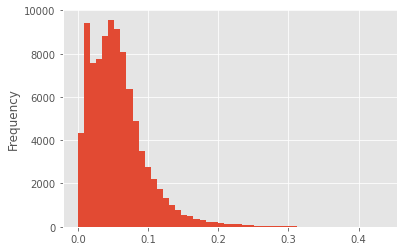

In [ ]:
train['target'].plot(kind='hist', bins=50)

In [ ]:
test.head(1)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,isTest
0,_wNsZEqpKUA,"Billie Eilish: Same Interview, The Fifth Year ...",2021-11-30 17:00:10+00:00,UCIsbLox_y9dCIMLd8tdC6qg,Vanity Fair,24,2021-12-01,billie|billie eilish|billie eilish 2021|billie...,https://i.ytimg.com/vi/_wNsZEqpKUA/default.jpg,False,False,I'm so much more open to stuff now. On the ver...,_wNsZEqpKUA_2021-12-01,1335.0,True,True


In [ ]:
# setup KFold


cfg = {
    'TARGET' : 'target',
    'N_FOLDS' :5,
    'RANDOM_STATE': 529,
    'N_ESTIMATORS' : 50_000,
    'LEARING_RATE': 0.1
}

train_vids = train['video_id'].unique()

In [ ]:
kf = KFold(n_splits=cfg["N_FOLDS"],
           shuffle=True,
           random_state=cfg['RANDOM_STATE'])
# creat foldes 
fold = 1
for tr_idx, val_idx in kf.split(train_vids):
  fold_vids = train_vids[val_idx]
  train.loc[train['video_id'].isin(fold_vids), 'fold'] = fold
  fold += 1

train['fold'] = train['fold'].astype('int')


In [ ]:
train.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target,fold,isTrain
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,NaN,True,0.103596,2,True
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,NaN,True,0.061611,3,True
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,NaN,True,0.173523,5,True
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,kXLn3HkpjaA_2020-08-12,NaN,True,0.046804,2,True
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,VIUo6yapDbc_2020-08-12,NaN,True,0.040753,3,True


In [ ]:
train['fold'].value_counts()
#all vid the rows

1    18688
5    18465
3    18437
4    18409
2    18276
Name: fold, dtype: int64

In [ ]:
#feuter enginering

def create_features(df, train=True):
  """
  Adds features to training or test set

  """
  df['publishedAt'] = pd.to_datetime(df['publishedAt'])
  df['trending_date'] = pd.to_datetime(df['trending_date'], utc=True)

  # f-1

  df['video_age_seconds'] = (df['trending_date'] - df['publishedAt']) \
  .dt.total_seconds().astype('int')

  # trading day week a catgory
  df['trending_dow'] = df['trending_date'].dt.day_name()
  df['trending_dow'] = df['trending_dow'].astype('category')

  df['published_dow'] = df['publishedAt'].dt.day_name()
  df['published_dow'] = df['published_dow'].astype('category')

  df['categoryId'] = df['categoryId'].astype('category')

  df['channel_occurance'] = df['channelId'].map(
      df['channelId'].value_counts().to_dict())

  df['channel_unique_video_count'] = df['channelId'].map(
      df.groupby('channelId')['video_id'].nunique().to_dict())
  
  df['video_occurance_count'] = df.groupby('video_id')['trending_date'] \
  .rank().astype('int')

  return df
  



In [ ]:


train['isTrain'] = True
test['isTrain'] = False
t_and_t = pd.concat([train, test]).reset_index(drop=True).copy()
t_and_t = create_features(t_and_t)
train_feats = t_and_t.query('isTrain').reset_index(drop=True).copy()
test_feats = t_and_t.query('isTrain == False').reset_index(drop=True).copy()

In [ ]:
#set target feauters

train_feats.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target,fold,isTrain,isTest,video_age_seconds,trending_dow,published_dow,channel_occurance,channel_unique_video_count,video_occurance_count
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12 00:00:00+00:00,brawadis|prank|basketball|skits|ghost|funny vi...,1514614.0,156908.0,5855.0,35313.0,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,NaN,True,0.103596,2.0,True,NaN,16786,Wednesday,Tuesday,35,5,1
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12 00:00:00+00:00,Apex Legends|Apex Legends characters|new Apex ...,2381688.0,146739.0,2794.0,16549.0,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,NaN,True,0.061611,3.0,True,NaN,25190,Wednesday,Tuesday,216,36,1
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12 00:00:00+00:00,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853.0,353787.0,2628.0,40221.0,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,NaN,True,0.173523,5.0,True,NaN,26754,Wednesday,Tuesday,112,19,1
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12 00:00:00+00:00,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771.0,23251.0,1856.0,7647.0,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,kXLn3HkpjaA_2020-08-12,NaN,True,0.046804,2.0,True,NaN,26465,Wednesday,Tuesday,111,22,1
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12 00:00:00+00:00,The LaBrant Family|DIY|Interior Design|Makeove...,1123889.0,45802.0,964.0,2196.0,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,VIUo6yapDbc_2020-08-12,NaN,True,0.040753,3.0,True,NaN,31795,Wednesday,Tuesday,56,11,1


In [ ]:
train_feats.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description', 'id', 'duration_seconds',
       'has_thumbnail', 'target', 'fold', 'isTrain', 'isTest',
       'video_age_seconds', 'trending_dow', 'published_dow',
       'channel_occurance', 'channel_unique_video_count',
       'video_occurance_count'],
      dtype='object')

In [ ]:
FEATURES = ['video_age_seconds',
            'trending_dow',
            'published_dow',
            'duration_seconds',
            'categoryId',
            'comments_disabled',
            'ratings_disabled',
            'channel_occurance',
            'channel_unique_video_count',
            'video_occurance_count'
]

TARGET = ['target']

In [ ]:
x_test = test_feats[FEATURES] 
oof = train_feats[['id','target','fold']].reset_index(drop=True).copy()
final_df = test[['id']].copy()

In [ ]:
x_test

,video_age_seconds,trending_dow,published_dow,duration_seconds,categoryId,comments_disabled,ratings_disabled,channel_occurance,channel_unique_video_count,video_occurance_count
0,25190,Wednesday,Tuesday,1335.0,24,False,False,62,11,1
1,95373,Wednesday,Monday,28.0,23,False,False,20,5,1
2,32306,Wednesday,Tuesday,728.0,27,False,False,176,28,1
3,28773,Wednesday,Tuesday,829.0,23,False,False,30,6,1
4,24298,Wednesday,Tuesday,31.0,23,False,False,20,5,1
...,...,...,...,...,...,...,...,...,...,...
5795,621049,Thursday,Wednesday,794.0,24,False,False,123,23,7
5796,704699,Thursday,Tuesday,456.0,24,False,False,53,9,8
5797,712789,Thursday,Tuesday,1010.0,24,False,False,61,11,8
5798,550789,Thursday,Thursday,24.0,20,False,False,15,3,7


In [ ]:
#crating models 
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

regs = []
fis = []

# example fold 1
for fold in range(1,6):
  print(f'====== Running for fold {fold} =====')
  # split train
  x_tr = train_feats.query('fold != @fold')[FEATURES]
  y_tr = train_feats.query('fold != @fold')[TARGET]
  x_val = train_feats.query('fold == @fold')[FEATURES]
  y_val = train_feats.query('fold == @fold')[TARGET]
  print(x_tr.shape, y_tr.shape, x_val.shape, y_val.shape)


reg = lgb.LGBMRegressor(n_estimators=cfg['N_ESTIMATORS'],
                        learning_rate=cfg['LEARING_RATE'],
                        objective='mae',
                        metric=['mae'],
                        importance_type='gain'
                        )

# fit model
reg.fit(x_tr, y_tr,
        eval_set=(x_val, y_val),
        early_stopping_rounds=5000,
        verbose=200,
        )

# predicting validation set
fold_preds = reg.predict(x_val,
                         num_iteration=reg.best_iteration_)
oof.loc[oof['fold'] == fold, 'preds'] = fold_preds

# score validation set 

fold_score = mean_absolute_error(
    oof.query('fold == @fold')['target'],
         oof.query('fold == @fold')['preds']
)

# crating a fetuter imp dframe

#fi = pd.DataFrame(index=reg.featuer_name_,
            #data=reg.featuer_importances_,
            #columns=[f'{fold}_importance'])
# predicting test
fold_test_pred = reg.predict(x_test,
                             num_itration=reg.best_iteration_)
final_df[f'pred_{fold}']= fold_test_pred
print(f'score of this fold is {fold_score:0.6f}')
regs.append(reg)
#fis.append(fi)
                         

====== Running for fold 1 =====
(73587, 10) (73587, 1) (18688, 10) (18688, 1)
====== Running for fold 2 =====
(73999, 10) (73999, 1) (18276, 10) (18276, 1)
====== Running for fold 3 =====
(73838, 10) (73838, 1) (18437, 10) (18437, 1)
====== Running for fold 4 =====
(73866, 10) (73866, 1) (18409, 10) (18409, 1)
====== Running for fold 5 =====
(73810, 10) (73810, 1) (18465, 10) (18465, 1)
Training until validation scores don't improve for 5000 rounds.
[200]	valid_0's l1: 0.0199392
[400]	valid_0's l1: 0.0195051
[600]	valid_0's l1: 0.019111
[800]	valid_0's l1: 0.0189622
[1000]	valid_0's l1: 0.0187775
[1200]	valid_0's l1: 0.0187975
[1400]	valid_0's l1: 0.0187127
[1600]	valid_0's l1: 0.0186895
[1800]	valid_0's l1: 0.0186816
[2000]	valid_0's l1: 0.0186932
[2200]	valid_0's l1: 0.0186945
[2400]	valid_0's l1: 0.0187145
[2600]	valid_0's l1: 0.0187234
[2800]	valid_0's l1: 0.0186955
[3000]	valid_0's l1: 0.0186798
[3200]	valid_0's l1: 0.0186722
[3400]	valid_0's l1: 0.0186687
[3600]	valid_0's l1: 0.0

In [ ]:
final_df

,id
0,_wNsZEqpKUA_2021-12-01
1,2jfbXZiE6Lc_2021-12-01
2,F1Hq8eVOMHs_2021-12-01
3,GQXVQmcGQUY_2021-12-01
4,n4XojTb6pfs_2021-12-01
...,...
5795,hJfpCXAMYPM_2021-12-30
5796,MbmTMEYnEzo_2021-12-30
5797,VG7arSAYvQI_2021-12-30
5798,SNb-g-hNYYs_2021-12-30
